## Denoising using Autoencoders
   #### Computer Vision Winter Semester 2021/2022 by Clemens Spielvogel
   
One task which can be accomplished using autoencoders is the removal of noise from images. In this case, the autoencoder has to be trained on feature-label pairs where the feature is an image containing noise and the label is an image without noise.  
In the following examples you will see how an autoencoder is used to remove different types of noise from hand-written digits to generate clean data. 

In [1]:
import numpy as np
import cv2
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Default matplotlib font color (change this to black if you are not using dark mode)
mpl.rcParams["text.color"] = "white"

There are many types of artificial noise which can be added to data. Here, three types of noise are used. Firstly, a gaussian noise where normal distributed values (in this case with mean 0 and a variance of 0.7) are added to the pixel values of the original image. Secondly, salt and pepper noise randomly changes pixel to have maximum or minimum numbers. Lastly, OpenCV is used to add a gaussian blur to the original image with a filter size of 17 x 17.

In [3]:
def add_gaussian_noise(image):
    """Returns the input image with gaussian noise added"""
    row, col = image.shape
    mean = 0
    var = 0.7
    sigma = var ** 0.5
    gaussian_noise = np.random.normal(mean, sigma, (row, col))

    return image + gaussian_noise

In [4]:
def add_salt_and_pepper_noise(image):
    """Returns the input image with salt and pepper noise added"""
    ratio_salt_to_pepper = 0.5
    amount = 0.4
    noised_image = np.copy(image)

    # Add salt noise
    num_salt = np.ceil(amount * image.size * ratio_salt_to_pepper)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noised_image[tuple(coords)] = 1

    # Add pepper noise
    num_pepper = np.ceil(amount * image.size * (1. - ratio_salt_to_pepper))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noised_image[tuple(coords)] = 0

    return noised_image

In [5]:
def add_blur(image):
    """Returns the blurred input image"""
    return cv2.GaussianBlur(image, (17, 17), 0)

In this case, a dense autoencoder is created with an input layer, a hidden layer with 128 nodes, a bottleneck layer with 64 nodes and another hidden layer with 128 nodes. After a regularization layer using dropout, the number of output nodes is set to be equal to the number of pixels of the original image. As the task can be seen as a pixelwise regression, mean squared error is used as loss function.

In [6]:
def create_dense_autoencoder_model(input_shape, num_bottleneck_nodes):
    """Fully connected autoencoder with 4 dense layers and drop-out"""
    model = Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(num_bottleneck_nodes, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(input_shape[0] * input_shape[1], activation="sigmoid"))
    model.add(layers.Reshape(input_shape))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

    return model

The plotting function is used to display the original image along with the noised image and the reconstructed image.

In [7]:
def plot(original, noised, pred):
    """Plotting corresponding original image, noise added image, and predicted image"""
    fig, ax = plt.subplots(3, 3)
    params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

    ax[0, 0].title.set_text("Original")
    ax[0, 1].title.set_text("Noised")
    ax[0, 2].title.set_text("Predicted")

    ax[0, 0].imshow(original[0])
    ax[0, 0].tick_params(**params)
    ax[0, 1].imshow(noised[0])
    ax[0, 1].tick_params(**params)
    ax[0, 2].imshow(pred[0])
    ax[0, 2].tick_params(**params)

    ax[1, 0].imshow(original[1])
    ax[1, 0].tick_params(**params)
    ax[1, 1].imshow(noised[1])
    ax[1, 1].tick_params(**params)
    ax[1, 2].imshow(pred[1])
    ax[1, 2].tick_params(**params)

    ax[2, 0].imshow(original[2])
    ax[2, 0].tick_params(**params)
    ax[2, 1].imshow(noised[2])
    ax[2, 1].tick_params(**params)
    ax[2, 2].imshow(pred[2])
    ax[2, 2].tick_params(**params)

    plt.tight_layout()
    plt.show()

In [8]:
def load_data():
    # Load data
    (train, _), (test, _) = mnist.load_data()  # Get training and test MNIST images

    # Get sample dimensions
    dims = train[0].shape

    # Normalize
    train = train.astype(np.float32) / 255
    test = test.astype(np.float32) / 255
    
    return train, test

Now we will add three different types of noise to the image and evaluate the autoencoders capabilities to denoise the images. We will start off with blurred images.

In [9]:
# Load images
train, test = load_data()

# Get dimensions of example image
dims = train[0].shape

In [10]:
# Add blur noise to images
train_noised = np.array([add_blur(image) for image in train])
test_noised = np.array([add_blur(image) for image in test])

In [11]:
# Set hyperparameters
num_epochs = 20
num_bottleneck_nodes = 32

# Create autoencoder model
model = create_dense_autoencoder_model(dims, num_bottleneck_nodes)

# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

# Train model
model.fit(train_noised,
          train,
          epochs=num_epochs,
          validation_data=(test_noised, test),
          verbose=True,
          callbacks=[callback])

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0408 - val_loss: 0.0261
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0265 - val_loss: 0.0215
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0242 - val_loss: 0.0197
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0228 - val_loss: 0.0187
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0220 - val_loss: 0.0177
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0213 - val_loss: 0.0170
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0207 - val_loss: 0.0165
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0203 - val_loss: 0.0160
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0199 - val_loss: 0.0156
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.019

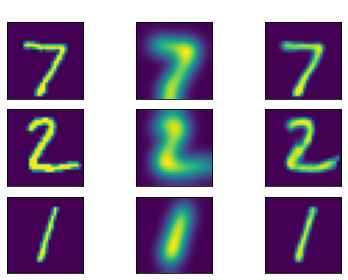

In [12]:
# Prediction and plotting of test samples
pred = model.predict(test_noised)
plot(test, test_noised, pred)

Next, we use salt-and-pepper noise to disort the images and evaluate the denoising autoencoder.

In [13]:
# Add salt-and-pepper noise to images
train_noised = np.array([add_salt_and_pepper_noise(image) for image in train])
test_noised = np.array([add_salt_and_pepper_noise(image) for image in test])

In [14]:
# Set hyperparameters
num_epochs = 20
num_bottleneck_nodes = 32

# Create autoencoder model
model = create_dense_autoencoder_model(dims, num_bottleneck_nodes)

# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

# Train model
model.fit(train_noised,
          train,
          epochs=num_epochs,
          validation_data=(test_noised, test),
          verbose=True,
          callbacks=[callback])

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0390 - val_loss: 0.0271
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0282 - val_loss: 0.0238
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0262 - val_loss: 0.0227
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0252 - val_loss: 0.0219
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0246 - val_loss: 0.0211
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0241 - val_loss: 0.0208
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0238 - val_loss: 0.0207
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0235 - val_loss: 0.0204
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0233 - val_loss: 0.0205
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.023

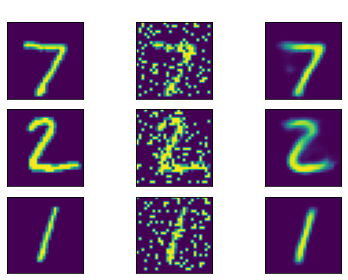

In [15]:
# Prediction and plotting of test samples
pred = model.predict(test_noised)
plot(test, test_noised, pred)

Lastly, gaussian noise is added and afterwards removed to reconstruct the denoised image.

In [16]:
# Add gaussian noise to images
train_noised = np.array([add_gaussian_noise(image) for image in train])
test_noised = np.array([add_gaussian_noise(image) for image in test])

In [17]:
# Set hyperparameters
num_epochs = 20
num_bottleneck_nodes = 32

# Create autoencoder model
model = create_dense_autoencoder_model(dims, num_bottleneck_nodes)

# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

# Train model
model.fit(train_noised,
          train,
          epochs=num_epochs,
          validation_data=(test_noised, test),
          verbose=True,
          callbacks=[callback])

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0421 - val_loss: 0.0312
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0322 - val_loss: 0.0288
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0304 - val_loss: 0.0277
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0294 - val_loss: 0.0270
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0288 - val_loss: 0.0267
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0283 - val_loss: 0.0263
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0280 - val_loss: 0.0262
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0277 - val_loss: 0.0260
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0275 - val_loss: 0.0260
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.027

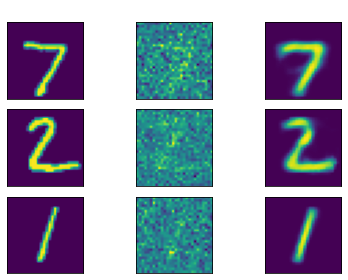

In [18]:
# Prediction and plotting of test samples
pred = model.predict(test_noised)
plot(test, test_noised, pred)